## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.fftpack
import pywt
import matplotlib.pyplot as plt
import cmath
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

## Clear Data

In [3]:
f_read = open("../data/WISDM/WISDM_ar_v1.1_raw.txt", "r")
f_write = open("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", "w")
for string in f_read.readlines():
    if string[-1] == '\n':
        string = string[:-1]
    if len(string) > 0:
        string_list = string.split(';')
        if len(string_list) > 2:
            for row in string_list[:2]:
                words = row.split(',')
                if len(words) > 5:
                    if len(words[5]) > 0:
                        f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                               words[2], words[3], 
                                                               words[4], words[5]))
        else:
            words = string_list[0].split(',')
            if len(words) > 5:
                if len(words[5]) > 0:
                    f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                           words[2], words[3], 
                                                           words[4], words[5]))
f_read.close()
f_write.close()

## Read Data

In [4]:
data_wisdm = pd.read_table("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", delimiter=',', header=None)
data_wisdm.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']

## Segmentation

Let us construct 10 seconds time series segments.
* each time series should be from one user and one type of activity;
* in the time series timestamp shouldn't differ more then 0.2 second (empirical rule, in ideal all timestamp should differ on 50 ms = 0.05 second).

In [5]:
def check_candidate(candidate, data_type, threshold=2.*1e8):
    if data_type == "USCHAD":
        threshold = 0.
    tsp = np.array(candidate['timestamp'])
    diffs = tsp[1:] - tsp[:-1]
    
    return np.sum(diffs > threshold) == 0

def get_time_series(accelerations, data_type, nb=200):
    accelerations.index = [i for i in range(len(accelerations))]
    TS = []
    st = 0
    fi = st + nb
    while fi < len(accelerations):
        candidate = accelerations.loc[[st + i for i in range(nb)], :]
        if check_candidate(candidate, data_type):
            TS.append([np.array(candidate['x']), 
                       np.array(candidate['y']), 
                       np.array(candidate['z'])])
        st = fi
        fi += nb
    
    return TS

## Feature Generation

In [6]:
def get_distribution(data, df):
    classes = list(set(data['activity']))
    for activity in classes:
        nb = np.sum(df['activity'] == classes.index(activity))
        print("{:<20}{:<9d}{:<5.2f} %".format(activity, nb, 100. * nb / df.shape[0]))
    print("")
    print("Number of objects: {:d}".format(df.shape[0]))

In [7]:
def get_feature_matrix(data, data_type, get_feature_names, get_features, params=[]):
    
    classes = list(set(data['activity']))
    feature_names = get_feature_names(params)
    df = pd.DataFrame(columns=['activity']+feature_names) 

    id_range = np.unique(np.array(data['id_user']))
    for id_user in id_range:
        for activity in classes:
            mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
            accelerations = data.loc[mask, ['timestamp', 'x', 'y', 'z']].copy()
            TS = get_time_series(accelerations, data_type, nb=200)
            for ts in TS:
                features = get_features(ts, params)
                df.loc[len(df), :] = [classes.index(activity)] + features
    return df

## Feature extraction

### Expert functions

The idea is the following: we will consider 10 seconds time series (or 200 points of measurements) and calculate 40 features:
* ```[3]``` - mean acceleration of each axis;
* ```[3]``` - std of acceleration of each axis;
* ```[3]``` - mean absolute deviation of acceleration of each axis;
* ```[1]``` - mean acceleration;
* ```[30]``` - distribution of time series values of each axis. First of all we calculate min and max of each component ($X, Y, Z$) from the whole interval. Then we divide the range of values of each component into 10 equal intervals and calculate on each each interval the percent of values that are in it (in the corresponding interval).  

And apply LogisticRegression and SVM.

In [8]:
def get_expert_names(params):
    feature_names = ['avg_x', 'avg_y', 'avg_z', 
                     'std_x', 'std_y', 'std_z', 
                     'abs_x', 'abs_y', 'abs_z', 'mean']
    for i in range(10):
        name = str(i) + '_'
        feature_names += [name + 'x', name + 'y', name + 'z']
        
    return feature_names

def get_expert_features(ts, params):
    x = ts[0]
    y = ts[1]
    z = ts[2]
    n = x.shape[0]
    features = []
    features.append(x.mean())
    features.append(y.mean())
    features.append(z.mean())
    features.append(x.std())
    features.append(y.std())
    features.append(z.std())
    features.append(np.abs(x - x.mean()).mean())
    features.append(np.abs(y - y.mean()).mean())
    features.append(np.abs(z - z.mean()).mean())
    features.append((x+y+z).mean() / 3.)
    x_range = np.linspace(x.min(), x.max(), 11)
    y_range = np.linspace(y.min(), y.max(), 11)
    z_range = np.linspace(z.min(), z.max(), 11)
    for i in range(10):
        features.append(1. * np.sum((x_range[i] <= x) & (x < x_range[i+1])) / n)
        features.append(1. * np.sum((y_range[i] <= y) & (y < y_range[i+1])) / n)
        features.append(1. * np.sum((z_range[i] <= z) & (z < z_range[i+1])) / n)
    
    return features

Create and save:

In [9]:
df_expert_wisdm = get_feature_matrix(data_wisdm, 'WISDM', get_expert_names, get_expert_features)
df_expert_wisdm.to_csv("../data/features/expert_wisdm.csv", index=False)

In [10]:
#df_expert_uschad = get_feature_matrix(data_uschad, 'USCHAD', get_expert_names, get_expert_features)
#df_expert_uschad.to_csv("../data/features/expert_uschad.csv", index=False)

### Autoregression model

### Explanation

In [10]:
def get_autoregressive_names(params):
    n = params[0]
    feature_names = []
    for ax in ['x', 'y', 'z']:
        feature_names += ['intercept_' + ax]
        for i in range(n):
            feature_names += ['coef_' + str(i) + '_' + ax]
            
    return feature_names

def get_autoregressive_features(ts, params):
    n = params[0]
    x = ts[0]
    y = ts[1]
    z = ts[2]
    m = x.shape[0]
    features = []
    X = np.zeros([m-n, n])
    Y = np.zeros(m-n)
    for axis in [x, y, z]:
        for i in range(m-n):
            X[i, :] = axis[i:i+n]
            Y[i] = axis[i+n]
        lr = LinearRegression()
        lr.fit(X, Y)
        features.append(lr.intercept_)
        features.extend(lr.coef_)
    
    return features

Create and save:

In [11]:
params = [20]
df_ar_wisdm = get_feature_matrix(data_wisdm, 'WISDM', get_autoregressive_names,
                                 get_autoregressive_features, params)
df_ar_wisdm.to_csv("../data/features/ar_wisdm.csv", index=False)

In [13]:
#params = [20]
#df_ar_uschad = get_feature_matrix(data_uschad, 'USCHAD', get_autoregressive_names,
#                                  get_autoregressive_features, params)
#df_ar_uschad.to_csv("../data/features/ar_uschad.csv", index=False)

## Over sampling 
3 and 5 classes correspond to upstairs and downstairs activities, which appear to be quite tricky to classify. We double both 3-d and 5-th classes for better training of the classifiers.

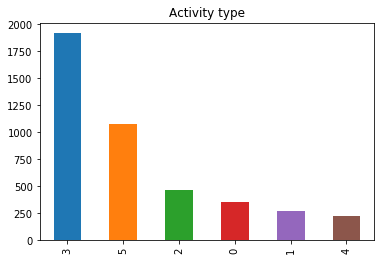

In [11]:
activity_type = df_ar_wisdm['activity'].value_counts().plot(kind='bar', title='Activity type')

In [17]:
df_ar_wisdm_sampled = df_ar_wisdm.append(df_ar_wisdm[df_ar_wisdm['activity']==2], ignore_index=True)
df_ar_wisdm_sampled = df_ar_wisdm_sampled.append(df_ar_wisdm[df_ar_wisdm['activity']==0], ignore_index=True)

In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy = 'not minority')
X_res, y_res = ros.fit_resample(df_ar_wisdm.drop('activity', axis=1), df_ar_wisdm['activity'])

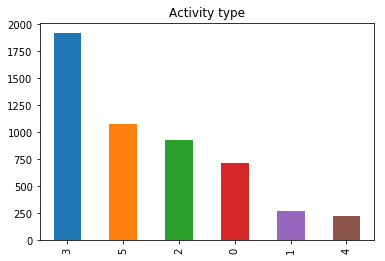

In [18]:
activity_type_sampled = df_ar_wisdm_sampled['activity'].value_counts().plot(kind='bar', title='Activity type')

### Spectrum analysis

### Explanation

In [12]:
def get_spectrum_names(params):
    n = params[0]
    feature_names = []
    for ax in ['x', 'y', 'z']:
        for i in range(n):
            feature_names += ['eigv_' + str(i) + '_' + ax]
            
    return feature_names

def get_spectrum_features(ts, params):
    n = params[0]
    x = ts[0]
    y = ts[1]
    z = ts[2]
    m = x.shape[0]
    features = []
    X = np.zeros([m-n, n])
    Y = np.zeros(m-n)
    for axis in [x, y, z]:
        for i in range(m-n):
            X[i, :] = axis[i:i+n]
        h = sc.linalg.svd(X.T.dot(X), compute_uv=False, overwrite_a=True)
        features.extend(h)
    
    return features

Create and save:

In [13]:
params = [20]
df_ssa_wisdm = get_feature_matrix(data_wisdm, 'WISDM', get_spectrum_names,
                                  get_spectrum_features, params)
df_ssa_wisdm.to_csv("../data/features/ssa_wisdm.csv", index=False)

In [77]:
df_ssa_wisdm.shape

(4321, 61)

In [16]:
#params = [20]
#df_ssa_uschad = get_feature_matrix(data_uschad, 'USCHAD', get_spectrum_names,
#                                   get_spectrum_features, params)
#df_ssa_uschad.to_csv("../data/features/ssa_uschad.csv", index=False)

## Fast Fourier Transform

### Explanation

In [118]:
def get_fft_names(params):
    n = params[0]//2
    feature_names = []
    for ax in ['x', 'y', 'z']:
        for i in range(2 *n):
            feature_names += ['fft_coef_' + str(i) + '_' + ax]
            
    return feature_names

def get_fft_features(ts, params):
    n = params[0]//2
    x = ts[0]
    y = ts[1]
    z = ts[2]
    m = x.shape[0]
    features = []
    #X = np.zeros([m-n, n])
    #Y = np.zeros(m-n)
    for axis in [x, y, z]:
        h = sc.fftpack.fft(axis, n, axis=-1, overwrite_x=False)
        features.extend(polar(h))
        
    return features

def polar (lis):
    c = []
    for i in range(len(lis)):
        c.extend(cmath.polar(lis[i]))
        
    return c

In [119]:
params = [20]
df_fft_wisdm = get_feature_matrix(data_wisdm, 'WISDM', get_fft_names,
                                 get_fft_features, params)
df_fft_wisdm.to_csv("../data/features/fft_wisdm.csv", index=False)

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


In [120]:
df_fft_wisdm.to_csv("../data/features/fft_wisdm.csv", index=False)

# Wavelet transform

## Explanation

In [99]:
def get_wvt_names(params):
    n = params[0]
    feature_names = []
    for ax in ['x', 'y', 'z']:
        for i in range(2*n):
            feature_names += ['wvt_coef_' + str(i) + '_' + ax]
            
    return feature_names

def get_wvt_features(ts, params):
    n = params[0]
    x = ts[0]
    y = ts[1]
    z = ts[2]
    m = x.shape[0]
    features = []
    for axis in [x, y, z]:
        h = pywt.dwt(axis, 'db1')
        features.extend(h[0][:n])
        features.extend(h[1][:n])

    return features

In [100]:
params = [20]
df_wvt_wisdm = get_feature_matrix(data_wisdm, 'WISDM', get_wvt_names,
                                 get_wvt_features, params)
df_wvt_wisdm.to_csv("../data/features/wvt_wisdm.csv", index=False)

In [23]:
df_wvt_wisdm.head(5)

,activity,wvt_coef_0_x,wvt_coef_1_x,wvt_coef_2_x,wvt_coef_3_x,wvt_coef_4_x,wvt_coef_5_x,wvt_coef_6_x,wvt_coef_7_x,wvt_coef_8_x,...,wvt_coef_30_z,wvt_coef_31_z,wvt_coef_32_z,wvt_coef_33_z,wvt_coef_34_z,wvt_coef_35_z,wvt_coef_36_z,wvt_coef_37_z,wvt_coef_38_z,wvt_coef_39_z
0,1,5.96091,7.98324,6.27911,6.05283,5.95384,1.20915,-4.75176,2.28395,12.3249,...,-3.19612,4.26385,-1.393,9.05097,2.5173,3.16784,7.26199,1.59806,2.03647,-0.0565685
1,1,-13.5411,-26.8418,-6.44174,6.66802,-19.9051,-18.8444,0,9.92071,-17.0625,...,1.65463,1.83848,-7.47412,7.63675,23.1931,0.275772,7.98324,-10.2672,1.03238,2.55266
2,1,-23.1295,-9.39745,12.3885,-1.492,-24.1618,-21.3971,-2.12132,0.487904,-26.5094,...,-0.480833,-7.84889,8.02566,-6.81651,3.0052,0.92631,-14.6866,0.79196,6.73873,-4.17193
3,1,8.87419,-18.4696,-25.1659,-12.5441,0.848528,-21.1001,-7.29027,11.8087,-7.12057,...,-1.43543,-1.04652,-0.537401,-8.47114,-4.12243,17.0483,-8.23072,-2.18496,-2.33345,2.7365
4,1,-21.5668,-11.1581,-3.67696,-26.7923,-1.54149,12.5087,-14.0502,-19.8273,-15.0826,...,-0.968736,5.3033,0,19.0141,7.69332,-4.63155,-1.32936,5.82656,-1.54149,5.79828


## All features

Concatenation of features from **all** algorithms:

In [103]:
df_all_wisdm = pd.concat([df_expert_wisdm, 
                          df_ar_wisdm.drop('activity', axis=1),
                          df_ssa_wisdm.drop('activity',axis=1), 
                          df_fft_wisdm.drop('activity', axis=1)], axis = 1, verify_integrity=True)
df_all_wisdm = df_all_wisdm.T.drop_duplicates().T

In [104]:
print('Expert: ', df_expert_wisdm.shape[1], '\nAR: ', df_ar_wisdm.shape[1],
      '\nSSA: ', df_ssa_wisdm.shape[1], '\nFFT: ', df_fft_wisdm.shape[1],
      '\nAll:', df_all_wisdm.shape[1])

Expert:  41 
AR:  64 
SSA:  61 
FFT:  121 
All: 257


In [105]:
print(df_all_wisdm.shape)
#print(df_all_wisdm['activity'])
df_all_wisdm.head(5)

(4321, 257)


,activity,avg_x,avg_y,avg_z,std_x,std_y,std_z,abs_x,abs_y,abs_z,...,fft_coef_21_z,fft_coef_23_z,fft_coef_25_z,fft_coef_27_z,fft_coef_29_z,fft_coef_31_z,fft_coef_33_z,fft_coef_35_z,fft_coef_37_z,fft_coef_39_z
0,0,-1.6131,7.36385,0.6642,9.13001,7.36329,6.18208,7.43719,5.87685,4.99227,...,0,-2.53611,0.77302,-1.83538,2.85347,-0.781865,-1.61574,1.68236,-1.37792,-2.47882
1,0,-6.677,1.5675,1.4811,9.71211,7.08923,6.62125,8.50786,6.12865,5.31728,...,0,1.30504,-1.26541,-1.44843,2.07659,2.92775,-1.41083,-2.28978,-3.06529,2.45443
2,0,-6.3839,-2.1543,1.2822,9.30458,8.04648,5.68264,7.99984,6.97681,4.45075,...,3.14159,1.0302,-0.319363,-2.7459,-2.89372,1.88145,-2.11438,-2.06603,1.31335,-2.41847
3,0,-6.9323,-2.8473,1.4422,8.97642,7.89286,6.49463,7.48564,6.75888,4.92815,...,0,-0.47398,-0.435701,0.615216,-2.04357,-1.71557,-1.68295,-0.476889,-1.46483,-3.04264
4,0,-2.20915,-5.6953,0.87955,8.12984,9.06241,4.47399,6.36119,7.57962,3.55842,...,0,-3.00778,1.46531,-2.65957,1.34011,-2.70536,-2.2812,2.27731,-2.4453,0.0866005


In [106]:
df_all_wisdm.to_csv("../data/features/all_wisdm.csv", index=False)

# Classification

## Read object-feature matrix

In [107]:
data_wisdm = pd.read_table("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", delimiter=',')
data_wisdm.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']

#data_uschad = pd.read_table("../data/USC-HAD/USC-HAD_cleared.txt", delimiter=',')
#data_uschad.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']

In [108]:
df_expert_wisdm = pd.read_csv("../data/features/expert_wisdm.csv")
df_ar_wisdm = pd.read_csv("../data/features/ar_wisdm.csv")
df_ssa_wisdm = pd.read_csv("../data/features/ssa_wisdm.csv")
df_fft_wisdm = pd.read_csv("../data/features/fft_wisdm.csv")
df_wvt_wisdm = pd.read_csv("../data/features/wvt_wisdm.csv")
df_all_wisdm = pd.read_csv("../data/features/all_wisdm.csv")

In [109]:
df_all_wisdm.head(5)

,activity,avg_x,avg_y,avg_z,std_x,std_y,std_z,abs_x,abs_y,abs_z,...,fft_coef_21_z,fft_coef_23_z,fft_coef_25_z,fft_coef_27_z,fft_coef_29_z,fft_coef_31_z,fft_coef_33_z,fft_coef_35_z,fft_coef_37_z,fft_coef_39_z
0,0,-1.61310,7.36385,0.66420,9.130013,7.363286,6.182081,7.437189,5.876850,4.992268,...,0.000000,-2.536114,0.773020,-1.835382,2.853471,-0.781865,-1.615743,1.682364,-1.377924,-2.478815
1,0,-6.67700,1.56750,1.48110,9.712106,7.089228,6.621250,8.507860,6.128650,5.317277,...,0.000000,1.305043,-1.265407,-1.448428,2.076589,2.927750,-1.410825,-2.289778,-3.065290,2.454433
2,0,-6.38390,-2.15430,1.28220,9.304576,8.046479,5.682636,7.999839,6.976815,4.450754,...,3.141593,1.030204,-0.319363,-2.745899,-2.893724,1.881448,-2.114382,-2.066034,1.313351,-2.418473
3,0,-6.93230,-2.84730,1.44220,8.976419,7.892858,6.494628,7.485639,6.758884,4.928154,...,0.000000,-0.473980,-0.435701,0.615216,-2.043573,-1.715573,-1.682954,-0.476889,-1.464832,-3.042640
4,0,-2.20915,-5.69530,0.87955,8.129835,9.062407,4.473987,6.361193,7.579624,3.558418,...,0.000000,-3.007780,1.465310,-2.659568,1.340111,-2.705358,-2.281203,2.277306,-2.445305,0.086601


In [110]:
def get_internal_score(clf, X, y, max_iter=11, oversample = False):
    nb = np.unique(y).shape[0]
    scores = np.zeros(nb+1)
    for j in range(max_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        if oversample==True:
            ros = RandomOverSampler(random_state=42, sampling_strategy = 'not minority')
            X_res, y_res = ros.fit_resample(X_train, y_train)
            clf.fit(X_res, y_res) 
        else:  
            clf.fit(X_train, y_train)    
        
        y_predict = clf.predict(X_test)   
        scores[0] += accuracy_score(y_test, y_predict)
        for i in range(nb):
            scores[i+1] += accuracy_score(1*(np.array(y_test) == i), 
                                          1*(np.array(y_predict) == i))
       
    return scores / max_iter

In [111]:
def get_score(df, estimator, params_grid, test_size=0.3, oversample=False):
    X = df.loc[:, df.columns != 'activity'].values
    y = df['activity'].values
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    clf = GridSearchCV(estimator, params_grid, cv = 3)
    clf.fit(X, list(y))
    clf_lr = clf.best_estimator_
    scores = get_internal_score(clf_lr, X, list(y), oversample = oversample)
    
    return scores

## Testing part 

In [121]:
parameters_lr = {'lr__penalty': ['l2', 'l1'],
                 'lr__class_weight': ['balanced', None], 
                 'lr__C': 10. ** np.arange(-1, 4, 1),
                 'lr__multi_class': ['ovr'],
                 'lr__solver': ['liblinear'],
                  'lr__max_iter': [200]}
parameters_svm = {'svc__kernel': ['rbf'], 
                  'svc__C': 10. ** np.arange(-1, 4, 1), 
                  'svc__gamma': 10. ** np.arange(-3, 2, 1),
                  'svc__class_weight': ['balanced', None]}

parameters_rf = {'n_estimators': [200], 
                 'class_weight': ['balanced', None], 
                 'max_depth': [None, 3, 5, 11]}

scores_wisdm = {}
scores_uschad = {}

In [122]:
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
rfc = RFC()

**Expert** features:

In [91]:
#scores_wisdm['lr_expert'] = get_score(df_expert_wisdm, lr_pipeline, parameters_lr)
#scores_wisdm['svm_expert'] = get_score(df_expert_wisdm, svc_pipeline, parameters_svm)
#scores_wisdm['rf_expert'] = get_score(df_expert_wisdm, rfc, parameters_rf)
scores_wisdm['lr_expert_sampled'] = get_score(df_expert_wisdm, lr_pipeline, parameters_lr, oversample=True)
scores_wisdm['svm_expert_sampled'] = get_score(df_expert_wisdm, svc_pipeline, parameters_svm, oversample=True)
scores_wisdm['rf_expert_sampled'] = get_score(df_expert_wisdm, rfc, parameters_rf, oversample=True)

From **autoregression model** features:

In [79]:
n = 20

In [86]:
%%time
#scores_wisdm['lr_ar_' + str(n)] = get_score(df_ar_wisdm, lr_pipeline, parameters_lr)
#scores_wisdm['svm_ar_' + str(n)] = get_score(df_ar_wisdm, svc_pipeline, parameters_svm)
#scores_wisdm['rf_ar_' + str(n)] = get_score(df_ar_wisdm, rfc, parameters_rf)
scores_wisdm['lr_ar_sampled_' + str(n)] = get_score(df_ar_wisdm, lr_pipeline, parameters_lr, oversample=True)
scores_wisdm['svm_ar_sampled_' + str(n)] = get_score(df_ar_wisdm, svc_pipeline, parameters_svm, oversample=True)
scores_wisdm['rf_ar_sampled_' + str(n)] = get_score(df_ar_wisdm, rfc, parameters_rf, oversample=True)

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: l

CPU times: user 8min 21s, sys: 14.4 s, total: 8min 35s
Wall time: 6min 32s


From **spectrum analysis** features:

In [66]:
n = 20

In [90]:
#scores_wisdm['lr_ssa_' + str(n)] = get_score(df_ssa_wisdm, lr_pipeline, parameters_lr)
#scores_wisdm['svm_ssa_' + str(n)] = get_score(df_ssa_wisdm, svc_pipeline, parameters_svm)
#scores_wisdm['rf_ssa_' + str(n)] = get_score(df_ssa_wisdm, rfc, parameters_rf)
scores_wisdm['lr_ssa_sampled_' + str(n)] = get_score(df_ssa_wisdm, lr_pipeline, parameters_lr, oversample=True)
scores_wisdm['svm_ssa_sampled_' + str(n)] = get_score(df_ssa_wisdm, svc_pipeline, parameters_svm, oversample=True)
scores_wisdm['rf_ssa_sampled_' + str(n)] = get_score(df_ssa_wisdm, rfc, parameters_rf, oversample=True)

From **Fourier transform** features:  

In [ ]:
%%time
scores_wisdm['lr_fft_sampled_'] = get_score(df_fft_wisdm, lr_pipeline, parameters_lr, oversample=True)
scores_wisdm['svm_fft_sampled_'] = get_score(df_fft_wisdm, svc_pipeline, parameters_svm, oversample=True)
scores_wisdm['rf_fft_sampled_'] = get_score(df_fft_wisdm, rfc, parameters_rf, oversample=True)

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ilyas/anaconda2/envs/py36/lib/python3.6/site-packages/skl

From **Wavelet transform** features:  

In [75]:
scores_wisdm['lr_wvt_sampled_'] = get_score(df_wvt_wisdm, lr_pipeline, parameters_lr, oversample=True)
scores_wisdm['svm_wvt_sampled_'] = get_score(df_wvt_wisdm, svc_pipeline, parameters_svm, oversample=True)
scores_wisdm['rf_wvt_sampled_'] = get_score(df_wvt_wisdm, rfc, parameters_rf, oversample=True)

From **ALL** features

In [115]:
#scores_wisdm['lr_all_feat_'] = get_score(df_all_wisdm, lr_pipeline, parameters_lr)
#scores_wisdm['svm_all_feat_'] = get_score(df_all_wisdm, svc_pipeline, parameters_svm)
#scores_wisdm['rf_all_feat_'] = get_score(df_all_wisdm, rfc, parameters_rf)
scores_wisdm['lr_all_feat_sampled_'] = get_score(df_all_wisdm, lr_pipeline, parameters_lr, oversample=True)
scores_wisdm['svm_all_feat_sampled_'] = get_score(df_all_wisdm, svc_pipeline, parameters_svm, oversample=True)
scores_wisdm['rf_all_feat_sampled_'] = get_score(df_all_wisdm, rfc, parameters_rf, oversample=True)

# Results

In [116]:
results_wisdm = pd.DataFrame.from_dict(scores_wisdm, orient='index').sort_index()
results_wisdm.columns = ['all'] + list(set(data_wisdm['activity']))
results_wisdm.to_csv("./results/results_wisdm_norm.csv")

In [117]:
results_wisdm

,all,Jogging,Upstairs,Standing,Walking,Downstairs,Sitting
lr_all_feat_sampled_,0.946450,0.993762,0.965094,0.995514,0.970561,0.970071,0.997897
lr_fft_sampled_,0.764071,0.970702,0.880704,0.987734,0.830308,0.866055,0.992640
rf_all_feat_sampled_,0.969090,0.991869,0.976870,0.998528,0.987594,0.985211,0.998108
rf_fft_sampled_,0.848812,0.977641,0.911264,0.995865,0.894372,0.922128,0.996355
svm_all_feat_sampled_,0.964183,0.994883,0.978972,0.995654,0.984229,0.979253,0.995374
svm_fft_sampled_,0.851616,0.978902,0.909161,0.996355,0.903834,0.918343,0.996636


In [93]:
results_wisdm = pd.DataFrame.from_dict(scores_wisdm, orient='index').sort_index()
results_wisdm.columns = ['all'] + list(set(data_wisdm['activity']))
results_wisdm.to_csv("./results/results_wisdm_norm.csv")

In [94]:
results_wisdm

,all,Jogging,Upstairs,Standing,Walking,Downstairs,Sitting
lr_expert_sampled,0.834653,0.981566,0.900610,0.989697,0.895984,0.912385,0.989066
lr_ssa_sampled_20,0.795612,0.986963,0.879933,0.990678,0.846569,0.897175,0.989907
rf_expert_sampled,0.945469,0.990187,0.966426,0.998528,0.966286,0.971473,0.998037
rf_ssa_sampled_20,0.931871,0.986753,0.961940,0.995234,0.957805,0.967057,0.994953
svm_expert_sampled,0.923460,0.989837,0.953739,0.991379,0.961730,0.959136,0.991098
svm_ssa_sampled_20,0.865003,0.991379,0.912666,0.992640,0.906077,0.935025,0.992220


In [ ]:
results_wisdm = pd.DataFrame.from_dict(scores_wisdm, orient='index').sort_index()
results_wisdm.columns = ['all'] + list(set(data_wisdm['activity']))
results_wisdm.to_csv("./results/results_wisdm_norm.csv")

In [ ]:
results_wisdm

In [55]:
scores_wisdm['rf_all_feat_sampled_'], clf = get_score(df_all_wisdm, rfc, parameters_rf, oversample=True)

In [58]:
hist([1,2,1])

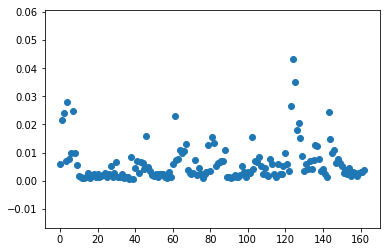

In [63]:
plt.scatter(range(len(clf.feature_importances_)),clf.feature_importances_)

In [83]:
scores_wisdm

{}